<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/main/13-GANs/GAN_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moskvicheva Polina мИИПИ22-2022

### WGAN

* Modify snippets below and implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with weight clipping. (2 points)

* Replace  weight clipping with [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (2 points)

* Add labels into WGAN, performing [conditional generation](https://arxiv.org/pdf/1411.1784.pdf). (2 points) 

Write a report about experiments and results, add plots and visualizations.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [3]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 6
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [4]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [5]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [6]:
len(dataloader)

3750

In [7]:
for image, cat in dataloader:
    break

In [8]:
image.size() #batch: 16 images, 1 channel, 28x28

torch.Size([16, 1, 28, 28])

### Create generator and discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [10]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")

### Create optimizers and loss

In [11]:
optim_G = torch.optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = torch.optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [12]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
input.to("cuda")
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
noise.to("cuda")
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
fixed_noise.to("cuda")
label = Variable(torch.FloatTensor(config.batch_size))
label.to("cuda")
real_label = 1
fake_label = 0

### WGAN

In [13]:
noise = noise.to("cuda")
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
weight_cliping_limit = 0.01


for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        
        # ####### 
        # # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        # #######
        # discriminator.zero_grad()
        
        # # real
        # label.data.fill_(real_label)
        # input_data = images.view(images.shape[0], -1)
        # output = discriminator(input_data)
        # errD_x = criterion(output, label)
        # ERRD_x[epoch] += errD_x.item()
        # errD_x.backward()
        
        # # fake 
        # noise.data.normal_(0, 1)
        # fake = generator(noise)
        # label.data.fill_(fake_label)
        # output = discriminator(fake.detach())
        # errD_z = criterion(output, label)
        # ERRD_z[epoch] += errD_z.item()
        # errD_z.backward()
        
        # optim_D.step()
        
        # ####### 
        # # Generator stage: maximize log(D(G(x))
        # #######
        # generator.zero_grad()
        # label.data.fill_(real_label)
        # output = discriminator(fake)
        # errG = criterion(output, label)
        # ERRG[epoch] += errG.item()
        # errG.backward()
        
        # optim_G.step()
       

        discriminator.zero_grad()

        input_data = images.view(images.shape[0], -1).to('cuda')

        noise.data.normal_(0, 1)

        for param in discriminator.parameters():
            param.data.clamp_(min=(-1)*weight_cliping_limit, max=weight_cliping_limit)

        if iteration % 5 == 0: 
            optim_G.zero_grad()
            fake = generator(noise)
            loss_G = discriminator(fake).mean()
            loss_G.backward()
            optim_G.step()

        fake_another = generator(noise)
        errD_x = discriminator(input_data).mean() - discriminator(fake_another.detach()).mean()
        errD_x.backward()
        optim_D.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f}'.format(epoch+1, iteration+1, errD_x.item()))

Epoch:1 Iter: 100 errD_x: -0.04
Epoch:1 Iter: 200 errD_x: -0.14
Epoch:1 Iter: 300 errD_x: -0.13
Epoch:1 Iter: 400 errD_x: -0.13
Epoch:1 Iter: 500 errD_x: -0.12
Epoch:1 Iter: 600 errD_x: -0.10
Epoch:1 Iter: 700 errD_x: -0.09
Epoch:1 Iter: 800 errD_x: -0.06
Epoch:1 Iter: 900 errD_x: -0.09
Epoch:1 Iter: 1000 errD_x: -0.05
Epoch:1 Iter: 1100 errD_x: -0.06
Epoch:1 Iter: 1200 errD_x: -0.05
Epoch:1 Iter: 1300 errD_x: -0.06
Epoch:1 Iter: 1400 errD_x: -0.04
Epoch:1 Iter: 1500 errD_x: -0.05
Epoch:1 Iter: 1600 errD_x: -0.04
Epoch:1 Iter: 1700 errD_x: -0.05
Epoch:1 Iter: 1800 errD_x: -0.04
Epoch:1 Iter: 1900 errD_x: -0.04
Epoch:1 Iter: 2000 errD_x: -0.04
Epoch:1 Iter: 2100 errD_x: -0.05
Epoch:1 Iter: 2200 errD_x: -0.05
Epoch:1 Iter: 2300 errD_x: -0.05
Epoch:1 Iter: 2400 errD_x: -0.06
Epoch:1 Iter: 2500 errD_x: -0.06
Epoch:1 Iter: 2600 errD_x: -0.05
Epoch:1 Iter: 2700 errD_x: -0.05
Epoch:1 Iter: 2800 errD_x: -0.05
Epoch:1 Iter: 2900 errD_x: -0.05
Epoch:1 Iter: 3000 errD_x: -0.05
Epoch:1 Iter: 3100 

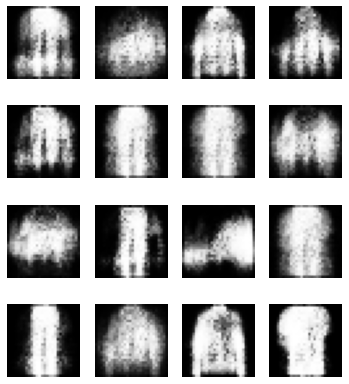

In [14]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN with gradient penalty

In [24]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")
optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
noise = noise.to("cuda")
N = len(dataloader)

In [25]:
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        input_data = images.view(images.shape[0], -1).to('cuda')
        noise.data.normal_(0, 1)
        discriminator.zero_grad()

        if iteration % 5 == 0:
            optim_G.zero_grad()
            noise.data.normal_(0, 1)
            fake = generator(noise)
            loss_G = (-1) * discriminator(fake).mean()
            loss_G.backward()
            optim_G.step()

        fake_another = generator(noise)
        discriminator_real = ((-1) * discriminator(input_data)).mean()
        discriminator_fake = discriminator(fake_another.detach()).mean()
        coef = torch.randn((input_data.shape[0], 1), device="cuda").uniform_(0, 1)
        x = coef * input_data + (1 - coef) * fake_another
        disc = discriminator(x)

        grad = torch.autograd.grad(outputs=disc.mean(), inputs=x, create_graph=True, retain_graph=True, only_inputs=True)
        grad_penalty = ((grad[0].norm(2, dim=1) - 1) ** 2).mean()

        errD_x = discriminator_real + discriminator_fake + grad_penalty
        errD_x.backward()
        optim_D.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f}'.format(epoch+1, iteration+1, errD_x.item()))

Epoch:1 Iter: 100 errD_x: 0.17
Epoch:1 Iter: 200 errD_x: -0.01
Epoch:1 Iter: 300 errD_x: -0.01
Epoch:1 Iter: 400 errD_x: -0.03
Epoch:1 Iter: 500 errD_x: -0.03
Epoch:1 Iter: 600 errD_x: -0.03
Epoch:1 Iter: 700 errD_x: -0.02
Epoch:1 Iter: 800 errD_x: 0.02
Epoch:1 Iter: 900 errD_x: -0.01
Epoch:1 Iter: 1000 errD_x: -0.03
Epoch:1 Iter: 1100 errD_x: -0.02
Epoch:1 Iter: 1200 errD_x: -0.03
Epoch:1 Iter: 1300 errD_x: -0.02
Epoch:1 Iter: 1400 errD_x: -0.02
Epoch:1 Iter: 1500 errD_x: -0.08
Epoch:1 Iter: 1600 errD_x: -0.05
Epoch:1 Iter: 1700 errD_x: -0.05
Epoch:1 Iter: 1800 errD_x: -0.06
Epoch:1 Iter: 1900 errD_x: -0.05
Epoch:1 Iter: 2000 errD_x: -0.11
Epoch:1 Iter: 2100 errD_x: -0.07
Epoch:1 Iter: 2200 errD_x: -0.01
Epoch:1 Iter: 2300 errD_x: 0.00
Epoch:1 Iter: 2400 errD_x: -0.17
Epoch:1 Iter: 2500 errD_x: -0.06
Epoch:1 Iter: 2600 errD_x: -0.17
Epoch:1 Iter: 2700 errD_x: -0.18
Epoch:1 Iter: 2800 errD_x: -0.07
Epoch:1 Iter: 2900 errD_x: -0.15
Epoch:1 Iter: 3000 errD_x: -0.13
Epoch:1 Iter: 3100 err

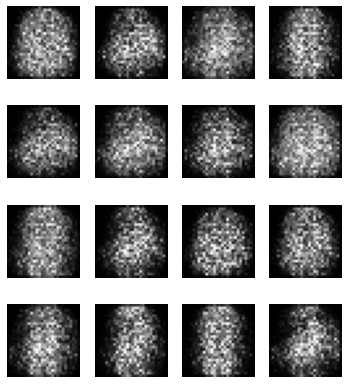

In [26]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')